# Data Exploration, Processing, and Model Fitting, Evaluation Notebook

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression

from tqdm import tqdm

plt.rcParams['figure.figsize'] = (15, 6)  # Width, Height in inches

pd.set_option("display.max_columns", 50)

# Data Processing

In [3]:
df = pd.read_csv("project_data.csv")

# fixing dates
df["date"] = pd.to_datetime(df["date"])

df

/var/folders/n5/2fld4dp113dfbc1h0f87y9_r0000gn/T/ipykernel_78838/29106677.py:1: DtypeWarning: Columns (6,7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("project_data.csv")


,player_id,name,position,points_won,start_rank,end_rank,tournament_id,R1,R2,R3,R4,R5,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible
0,449.0,Mark McNulty,1,10.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
1,440.0,David Frost,2,6.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
2,446.0,Tony Johnstone,3,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
3,95.0,Rick Hartmann,T4,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
4,265.0,David Feherty,T4,4.0,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,5,1986,1986-02-02,Wild Coast Class,0.0,2,Sunshine Tour,Afr,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140530,19455.0,Guillermo Mito Pereira,T47,NaN,NaN,NaN,36_liv,73.0,71.0,71.0,NaN,NaN,215.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140531,12337.0,Jason Kokrak,51,NaN,NaN,NaN,36_liv,73.0,73.0,70.0,NaN,NaN,216.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140532,15856.0,Cameron Smith,52,NaN,NaN,NaN,36_liv,73.0,73.0,74.0,NaN,NaN,220.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False
1140533,14706.0,Hudson Swafford,53,NaN,NaN,NaN,36_liv,78.0,78.0,67.0,NaN,NaN,223.0,37,2024,2024-09-15,Chicago_liv,NaN,41,Liv Golf,liv,False


In [ ]:
# Melt the dataframe
df_melted = pd.melt(
    df,
    id_vars=['player_id', 'name', 'position', 'points_won', 'start_rank', 'end_rank',
       'tournament_id', 'total', 'week', 'year',
       'date', 'event', 'field_rating', 'tour_id', 'tour_name', 'tour_code',
       'is_eligible'],  # Columns to keep
    value_vars=['R1', 'R2', 'R3', 'R4', 'R5'],  # Columns to unpivot
    var_name='Round',  # Name for the new 'Round' column
    value_name='Score'  # Name for the new 'Score' column
)

df_melted['Score'] = df_melted['Score'].replace("-", np.nan)
df_melted = df_melted.dropna(subset="Score")
df_melted["Score"] = df_melted["Score"].astype(float).astype(int)
df_melted = df_melted[df_melted["Score"] > 55]
df_melted = df_melted[df_melted["Score"] < 100]

df_melted["Round"] = df_melted['Round'].replace("R1", 1).replace("R2", 2).replace("R3", 3).replace("R4", 4).replace("R5", 5)

tournaments = df_melted["tournament_id"].unique()

tourney_d = {}
for i in range(len(tournaments)):
    tourney_d[tournaments[i]] = i

df_melted["tourney_id"] = df_melted["tournament_id"].map(tourney_d)

# Get all unique pairs from 'tournament_id' and 'Round'
unique_pairs = df_melted[['tourney_id', 'Round']].drop_duplicates()

# Convert to a list of tuples if needed
unique_pairs_list = list(unique_pairs.itertuples(index=False, name=None))

tourney_rounds_d = {}
for i in range(len(unique_pairs_list)):
    tourney_rounds_d[unique_pairs_list[i]] = i

df_melted['tournament_round'] = list(zip(df_melted['tourney_id'], df_melted['Round']))
df_melted["tournament_round"] = df_melted["tournament_round"].map(tourney_rounds_d)

df_melted["player_id"] = df_melted["player_id"].astype(int)

tournament_round_scores = dict(df_melted.groupby("tournament_round")["Score"].mean())
df_melted["round_scoring_average"] = df_melted["tournament_round"].map(tournament_round_scores)
df_melted["raw_strokes_gained"] = df_melted["round_scoring_average"] - df_melted["Score"]

df_melted = df_melted[~((df_melted["raw_strokes_gained"] >= 10)&((df_melted["position"] == "WD")|(df_melted["position"] == "MC")))]

tournament_round_scores = dict(df_melted.groupby("tournament_round")["Score"].mean())
df_melted["round_scoring_average"] = df_melted["tournament_round"].map(tournament_round_scores)
df_melted["raw_strokes_gained"] = df_melted["round_scoring_average"] - df_melted["Score"]

bad_events = df_melted[df_melted["round_scoring_average"] < 65].tournament_id.unique()
df_melted = df_melted[~df_melted["tournament_id"].isin(bad_events)]

# some random outlier eventd
df_melted = df_melted[df_melted["event"] != "Master of the Monster"]

years = df_melted["year"].unique()

year_bucket_dict = {}

# just splits regressions into two year buckets, with the first being 3 years if an odd number of years
if len(years) % 2 == 1:
    for i in range(0, 3):
        year_bucket_dict[years[i]] = 0
    for i in range(3, len(years)):
        year_bucket_dict[years[i]] = (i-1) // 2
else:
    for i in range(len(years)):
        year_bucket_dict[years[i]] = i // 2
    
df_melted["regression_bucket"] = df_melted["year"].map(year_bucket_dict)
df_melted

,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket
410520,9365,James Heath,1,12.00,406.0,259.0,3599,261,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0
410521,6513,Thomas Norret,2,7.20,1269.0,624.0,3599,264,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,69,0,0,69.774194,0.774194,0
410522,8135,Felipe Aguilar,T3,4.20,540.0,439.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0
410523,9199,Roope Kakko,T3,4.20,774.0,627.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0
410524,6166,Birgir Hafthorsson,T5,2.64,962.0,742.0,3599,266,34,2006,2006-08-27,ECCO Tour Championship,2.0,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5106807,10180,Michael Putnam,T68,0.00,356.0,363.0,4722,349,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,72,943,20553,69.410959,-2.589041,2
5106808,14013,Cameron Tringale,T68,0.00,529.0,532.0,4722,349,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,74,943,20553,69.410959,-4.589041,2
5106809,3682,Scott McCarron,71,0.00,366.0,371.0,4722,350,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,78,943,20553,69.410959,-8.589041,2
5106810,6300,John Rollins,T72,0.00,173.0,178.0,4722,351,3,2011,2011-01-23,Bob Hope Classic,163.0,23,PGA Tour,PGAT,True,5,75,943,20553,69.410959,-5.589041,2


## Fixed Effects Regression -> Adjusted Strokes Gained

In [ ]:
dfs = [group for _, group in df_melted.groupby("regression_bucket")]

# calculates fixed effects regression in two year periods
for i in tqdm(range(len(dfs))):
    # Initialize OneHotEncoder with sparse=True
    player_encoder = OneHotEncoder(sparse=True, dtype='float32')
    event_encoder = OneHotEncoder(sparse=True, dtype='float32')

    # Encode 'player' and 'event_round' columns
    player_dummies = player_encoder.fit_transform(dfs[i][['player_id']])
    event_dummies = event_encoder.fit_transform(dfs[i][['tournament_round']])

    # Combine the sparse matrices
    X_sparse = hstack([player_dummies, event_dummies], format='csr')

    y = dfs[i]["raw_strokes_gained"].values

    # Fit a regression using scikit-learn
    model = LinearRegression(fit_intercept=False)
    model.fit(X_sparse, y)

    players = player_encoder.categories_[0]

    player_rating_dict = dict(zip(players, model.coef_[:len(players)]))

    dfs[i]["estimated_player_rating"] = dfs[i]["player_id"].map(player_rating_dict)

    rounds = event_encoder.categories_[0]

    round_rating_dict = dict(zip(rounds, model.coef_[len(players):]))

    dfs[i]["estimated_round_rating"] = dfs[i]["tournament_round"].map(round_rating_dict)

    pga_tour_benchmark = dfs[i][dfs[i]["tour_code"] == "PGAT"]["estimated_round_rating"].mean()

    dfs[i]["estimated_round_rating"] = dfs[i]["estimated_round_rating"] - pga_tour_benchmark

    dfs[i]["estimated_player_rating"] = dfs[i]["estimated_player_rating"] - pga_tour_benchmark

    dfs[i]["adjusted_strokes_gained"] = dfs[i]["raw_strokes_gained"] - dfs[i]["estimated_round_rating"]

df1 = pd.concat(dfs)
df1

100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained
410520,9365,James Heath,1,12.00000,406.0,259.0,3599,261,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0,1.447872,3.118544,1.655650
410521,6513,Thomas Norret,2,7.20000,1269.0,624.0,3599,264,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,69,0,0,69.774194,0.774194,0,1.992350,3.118544,-2.344350
410522,8135,Felipe Aguilar,T3,4.20000,540.0,439.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,65,0,0,69.774194,4.774194,0,2.990305,3.118544,1.655650
410523,9199,Roope Kakko,T3,4.20000,774.0,627.0,3599,265,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0,2.005417,3.118544,0.655650
410524,6166,Birgir Hafthorsson,T5,2.64000,962.0,742.0,3599,266,34,2006,2006-08-27,ECCO Tour Championship,2.00000,10,Challenge Tour,Cha,True,1,66,0,0,69.774194,3.774194,0,1.777964,3.118544,0.655650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560151,14419,Jiho Yang,T57,0.09921,727.0,730.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,71,5414,20548,68.819672,-2.180328,8,2.982506,1.600478,-3.780805
4560152,19163,Taiko Nishiyama,T57,0.09921,893.0,897.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,76,5414,20548,68.819672,-7.180328,8,3.057283,1.600478,-8.780805
4560153,26547,Kazuma Manabe(Am),T57,0.09921,2677.0,2447.0,10603,283,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,74,5414,20548,68.819672,-5.180328,8,2.641006,1.600478,-6.780805
4560154,17829,Shotaro Wada,60,0.08870,2615.0,2436.0,10603,285,40,2024,2024-10-06,ACN Championship Golf Tournament,33.52272,15,Japan Golf Tour,Jpn,True,4,69,5414,20548,68.819672,-0.180328,8,1.469022,1.600478,-1.780805


# Data Exploration

## Feature Building

### Halflife Function

In [ ]:
# Parameters
halflife_in_days = 100  # Halflife in days
ln2 = np.log(2)
min_rounds = 20
max_window_in_days = 2*365

# Function to compute weights
def compute_weights(dates, current_date, halflife_in_days=halflife_in_days):
    lambda_ = -ln2 / halflife_in_days  # Compute lambda once for efficiency
    # Calculate days between the current date and all other dates
    days_between = (current_date - dates) / pd.Timedelta(1, "d")
    # Compute weights using the formula w = e^(-lambda * t), enforcing max_window_in_days
    weights = np.where(
        days_between > max_window_in_days,  # If days_between exceeds max window
        0,  # Set weight to 0
        np.exp(lambda_ * days_between)  # Otherwise, compute weight
    )
    # Enforce min_rounds: return all 0s if nonzero weights < min_rounds
    if np.count_nonzero(weights) < min_rounds:
        return np.zeros_like(weights)
    return weights

# Function to calculate EWMA
def calculate_ewma(df, halflife_in_days=halflife_in_days, min_rounds=min_rounds, max_window_in_days=max_window_in_days):
    ewma = []
    for i in range(len(df)):
        current_date = df.loc[i, "Date"]
        # Compute weights for all rows up to the current row
        weights = compute_weights(df.loc[:i, "Date"], current_date, halflife_in_days)
        # Weighted average: sum of weighted values / sum of weights
        weighted_sum = np.sum(weights * df.loc[:i, "adjusted_strokes_gained"])
        weight_sum = np.sum(weights)
        if weight_sum == 0:
            ewma.append(np.nan)
        else:
            ewma.append(weighted_sum / weight_sum)
    return ewma

# this is the function to use, as it does the same thing, but vectorized, so much more performant
def calculate_ewma_optimized(df, halflife_in_days=365, min_rounds=20, max_window_in_days=2 * 365):
    dates = df["Date"].values
    values = df["adjusted_strokes_gained"].values
    n = len(df)
    
    ln2 = np.log(2)
    lambda_ = -ln2 / halflife_in_days  # Decay rate

    # Precompute time differences (days between dates)
    time_diffs = (dates[:, None] - dates) / np.timedelta64(1, "D")
    
    # Compute weights
    valid_mask = time_diffs <= max_window_in_days
    # don't include today's round, or any rounds in the future
    positive_mask = time_diffs > 0
    weights = np.exp(lambda_ * time_diffs) * valid_mask * positive_mask

    # # Ensure that rows with fewer than min_rounds valid weights are excluded
    valid_counts = (valid_mask * positive_mask).cumsum(axis=1).diagonal()

    # Compute cumulative sums for weighted values and weights
    weighted_sums = (weights * values[None, :]).cumsum(axis=1)
    weight_sums = weights.cumsum(axis=1)

    # Compute EWMA: weighted_sums / weight_sums, only where weight_sums > 0
    ewma_matrix = np.full_like(weight_sums, np.nan) # start with nans
    mask = (weight_sums > 0) & (valid_counts >= min_rounds)
    ewma_matrix[mask] = weighted_sums[mask] / weight_sums[mask]

    # Extract the diagonal (final EWMA for each row)
    return ewma_matrix[np.arange(n), np.arange(n)]


In [520]:
df1 = df1.sort_values(by=["date", "Round"]).reset_index(drop=True)

df1["Date"] = df1["date"] + pd.to_timedelta(df1["Round"], "D")

dfs = [group.reset_index(drop=True) for _, group in df1.groupby("player_id")]

player_id_dict = {}
player_name_dict = {}
for i in tqdm(range(len(dfs))):
    # player_id_dict[dfs[i].player_id.values[0]] = i
    # player_name_dict[dfs[i].name.values[0]] = i

    dfs[i]["ewma_2yr"] = calculate_ewma_optimized(dfs[i], halflife_in_days=2*365)
    dfs[i]["ewma_1yr"] = calculate_ewma_optimized(dfs[i], halflife_in_days=365)
    dfs[i]["ewma_1mth"] = calculate_ewma_optimized(dfs[i], halflife_in_days=30)
    dfs[i]["ewma_3mth"] = calculate_ewma_optimized(dfs[i], halflife_in_days=90)
    dfs[i]["ewma_1wk"] = calculate_ewma_optimized(dfs[i], halflife_in_days=7)

df2 = pd.concat(dfs)

df2 = df2.dropna(subset=["ewma_1yr", "ewma_1mth", "ewma_3mth", "ewma_1wk"]).reset_index(drop=True)


100%|██████████| 24712/24712 [02:08<00:00, 192.69it/s] 


## Model Fitting

### Linear Model

In [544]:
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score

# Calculate split indices
n = len(df2)
train_end = int(0.6 * n)  # 60% for training
test_end = int(0.8 * n)    # Next 20% for validation

# Split the data chronologically
train = df2.iloc[:train_end]
test = df2.iloc[train_end:test_end]
val = df2.iloc[test_end:]

# Print the sizes of each split
print(f"Train size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")

# Define the formula (replace 'y', 'x', and 'z' with actual column names)
formula = "adjusted_strokes_gained ~ ewma_1yr + ewma_3mth + ewma_1mth + ewma_1wk"

# Fit the model on the training data
model = smf.ols(formula=formula, data=train).fit()

# Print the model summary
print(model.summary())

# Make predictions on the validation and test sets
test_predictions = model.predict(test)

# Evaluate the model on the validation set
test_rmse = mean_squared_error(test["adjusted_strokes_gained"], test_predictions)
test_r2 = r2_score(test["adjusted_strokes_gained"], test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R-squared: {test_r2}")

Train size: 1018707, Validation size: 339570, Test size: 339569
                               OLS Regression Results                              
Dep. Variable:     adjusted_strokes_gained   R-squared:                       0.189
Model:                                 OLS   Adj. R-squared:                  0.189
Method:                      Least Squares   F-statistic:                 5.917e+04
Date:                     Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                             00:24:56   Log-Likelihood:            -2.5199e+06
No. Observations:                  1018707   AIC:                         5.040e+06
Df Residuals:                      1018702   BIC:                         5.040e+06
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

In [514]:
import xgboost as xgb

# Define features and target variable
features = ["ewma_1yr", "ewma_3mth", "ewma_1mth", "ewma_1wk"]
target = "adjusted_strokes_gained"

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # For regression tasks
    n_estimators=1000,             # Number of boosting rounds
    learning_rate=0.1,             # Learning rate
    max_depth=5,                   # Maximum tree depth
    subsample=0.8,                 # Subsample ratio
    colsample_bytree=0.8,          # Feature column sampling
    early_stopping_rounds=50       # Stop training if validation score doesn't improve
)

# Train the model using early stopping on validation set
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=True
)

# Predictions
test_predictions = xgb_model.predict(X_test)

# Evaluate the model
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_r2 = r2_score(y_test, test_predictions)

print(f"Test RMSE: {test_rmse}")
print(f"Test R-squared: {test_r2}")

[0]	validation_0-rmse:4.12479
[1]	validation_0-rmse:3.93020
[2]	validation_0-rmse:3.76640
[3]	validation_0-rmse:3.62787
[4]	validation_0-rmse:3.51095
[5]	validation_0-rmse:3.41338
[6]	validation_0-rmse:3.33185
[7]	validation_0-rmse:3.26214
[8]	validation_0-rmse:3.20472
[9]	validation_0-rmse:3.15711
[10]	validation_0-rmse:3.11803
[11]	validation_0-rmse:3.08587
[12]	validation_0-rmse:3.05942
[13]	validation_0-rmse:3.03842
[14]	validation_0-rmse:3.02047
[15]	validation_0-rmse:3.00584
[16]	validation_0-rmse:2.99394
[17]	validation_0-rmse:2.98452
[18]	validation_0-rmse:2.97639
[19]	validation_0-rmse:2.96976
[20]	validation_0-rmse:2.96436
[21]	validation_0-rmse:2.96003
[22]	validation_0-rmse:2.95641
[23]	validation_0-rmse:2.95348
[24]	validation_0-rmse:2.95107
[25]	validation_0-rmse:2.94906
[26]	validation_0-rmse:2.94758
[27]	validation_0-rmse:2.94627
[28]	validation_0-rmse:2.94510
[29]	validation_0-rmse:2.94418
[30]	validation_0-rmse:2.94345
[31]	validation_0-rmse:2.94284
[32]	validation_0-

In [486]:
df2.columns

Index(['df2_index', 'player_id', 'name', 'position', 'points_won',
       'start_rank', 'end_rank', 'tournament_id', 'total', 'week', 'year',
       'date', 'event', 'field_rating', 'tour_id', 'tour_name', 'tour_code',
       'is_eligible', 'Round', 'Score', 'tourney_id', 'tournament_round',
       'round_scoring_average', 'raw_strokes_gained', 'regression_bucket',
       'estimated_player_rating', 'estimated_round_rating',
       'adjusted_strokes_gained', 'Date', 'ewma_1yr', 'ewma_1mth', 'ewma_3mth',
       'ewma_1wk'],
      dtype='object')

In [487]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697846 entries, 0 to 1697845
Data columns (total 33 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   df2_index                int64         
 1   player_id                int64         
 2   name                     object        
 3   position                 object        
 4   points_won               float64       
 5   start_rank               float64       
 6   end_rank                 float64       
 7   tournament_id            object        
 8   total                    object        
 9   week                     int64         
 10  year                     int64         
 11  date                     datetime64[ns]
 12  event                    object        
 13  field_rating             float64       
 14  tour_id                  int64         
 15  tour_name                object        
 16  tour_code                object        
 17  is_eligible              bo

0:	learn: 3.2546680	test: 3.5185872	best: 3.5185872 (0)	total: 131ms	remaining: 2m 10s
100:	learn: 2.8936796	test: 2.9156246	best: 2.9156246 (100)	total: 2.66s	remaining: 23.7s
200:	learn: 2.8909305	test: 2.9125040	best: 2.9125040 (200)	total: 4.85s	remaining: 19.3s
300:	learn: 2.8892628	test: 2.9109447	best: 2.9109447 (300)	total: 6.96s	remaining: 16.2s
400:	learn: 2.8876304	test: 2.9097426	best: 2.9097426 (400)	total: 9.08s	remaining: 13.6s
500:	learn: 2.8863140	test: 2.9092420	best: 2.9092420 (500)	total: 11.3s	remaining: 11.2s
600:	learn: 2.8852001	test: 2.9090483	best: 2.9090450 (591)	total: 13.4s	remaining: 8.87s
700:	learn: 2.8841845	test: 2.9088811	best: 2.9088706 (683)	total: 15.5s	remaining: 6.61s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 2.908870576
bestIteration = 683

Shrink model to first 684 iterations.
Test RMSE: 2.9089
Test R^2: 0.3139
                Feature Id  Importances
0  estimated_player_rating    40.612080
1                 ewma_1yr    2

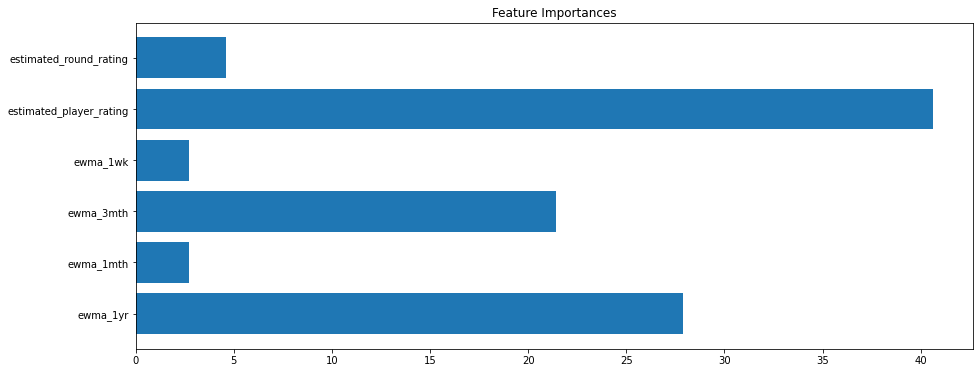

In [515]:
from catboost import CatBoostRegressor, Pool

# Define target (y) and features (X)
target = "adjusted_strokes_gained"  # Replace with your target column
features = [
    'ewma_1yr', 'ewma_1mth', 'ewma_3mth', 'ewma_1wk', 'estimated_player_rating', 'estimated_round_rating',
]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

# 2. Identify Categorical Features
categorical_features = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

# 3. Initialize CatBoost Regressor
catboost_model = CatBoostRegressor(
    iterations=1000,          # Number of boosting iterations
    learning_rate=0.05,       # Learning rate
    depth=6,                  # Maximum tree depth
    loss_function="RMSE",     # Loss function for regression
    cat_features=categorical_features,  # Pass categorical features
    early_stopping_rounds=50, # Stop if validation loss doesn't improve
    verbose=100               # Show training progress every 100 iterations
)

# 4. Prepare Data Pools (Optional but improves efficiency)
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# 5. Fit the Model
catboost_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True       # Use the best model based on validation set
)

y_test_pred = catboost_model.predict(X_test)

test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# 7. Feature Importance
import matplotlib.pyplot as plt

feature_importances = catboost_model.get_feature_importance(prettified=True)
print(feature_importances)

# Plot feature importance
plt.barh(X_train.columns, catboost_model.feature_importances_)
plt.title("Feature Importances")
plt.show();

## Ranking from Model

In [545]:
df3 = df2.sort_values(by=["date", "Round"]).reset_index(drop=True).reset_index()
df3 = df3.rename(columns={"index": "df3_index"})
 
start_date = df3.date.values[int(0.5*len(df))]
end_date = df3.date.values[-1]
date_range_in_days = (end_date - start_date) / pd.Timedelta(1, "D")
date_range_in_days

ranking_days = []

for i in range(int(date_range_in_days)):
    if i % 7 == 0:
        ranking_days.append(start_date + pd.Timedelta(i, "D"))

player_date_dict = {}

dfs2 = [group.reset_index(drop=True) for _, group in df3.groupby("player_id")]
for i in range(len(dfs2)):
    player_date_dict[dfs2[i].player_id.values[0]] = (dfs2[i].date.min(), dfs2[i].date.max())

ranking_dates_players = {}

for i in tqdm(range(len(ranking_days))):
    ranking_dates_players[ranking_days[i]] = []
    for key in player_date_dict.keys():
        # allow a player to be ranked for one year after their last round in the database
        if ranking_days[i] > player_date_dict[key][0] and ranking_days[i] <= player_date_dict[key][1] + pd.Timedelta(365, "D"):
            ranking_dates_players[ranking_days[i]].append(key)

ranking_dfs = []
for i in tqdm(range(len(ranking_days))):
    ranking_date = list(ranking_dates_players.keys())[i]
    ranking_players = ranking_dates_players[ranking_date]

    ranking_df = df3[(df3["date"] <= ranking_date)&(df3["player_id"].isin(ranking_players))].drop_duplicates("player_id", keep="last")
    ranking_df["model_prediction"] = model.predict(ranking_df)
    ranking_df = ranking_df.sort_values(by="model_prediction", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index": "model_ranking"})
    
    # want ranking to be 1-indexed, not 0-indexed
    ranking_df["model_ranking"] = ranking_df["model_ranking"] + 1

    if i == len(ranking_days) - 1:
        display(ranking_df)

    ranking_dfs.append(ranking_df)

ranking_df = pd.concat(ranking_dfs)
df3 = df3.merge(ranking_df[["df3_index", "model_ranking", "model_prediction"]], on="df3_index", how="left")

df3 = df3.drop_duplicates("df3_index", keep="first").reset_index(drop=True)
df3

100%|█████████▉| 529/531 [00:49<00:00,  8.17it/s]

,model_ranking,df3_index,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained,Date,ewma_2yr,ewma_1yr,ewma_1mth,ewma_3mth,ewma_1wk,model_prediction
0,1,1682144,18417,Scottie Scheffler,3,18.09877,1.0,1.0,10545,264,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,4,67,5354,20514,67.866667,0.866667,8,8.185462,-1.374388,2.241054,2024-09-05,3.133628,3.175401,3.066391,3.259739,2.968539,2.954273
1,2,1682177,19895,Xander Schauffele,T13,4.10794,2.0,2.0,10545,273,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,4,68,5354,20514,67.866667,-0.133333,8,7.613532,-1.374388,1.241054,2024-09-05,2.660364,2.721419,2.931253,2.955015,2.481285,2.564298
2,3,1694018,19195,Jon Rahm,2,15.03699,15.0,13.0,10585,270,39,2024,2024-09-29,acciona Open de España presented by Madrid,145.71344,13,DP World Tour,DPWT,True,4,68,5398,20537,69.942029,1.942029,8,7.492116,0.425213,1.516816,2024-10-03,2.557518,2.546003,3.363255,2.789821,3.632937,2.510045
3,4,1690737,10091,Rory McIlroy,T2,16.99096,3.0,3.0,10578,268,38,2024,2024-09-22,BMW PGA Championship,197.57772,13,DP World Tour,DPWT,True,4,67,5387,20532,69.307692,2.307692,8,7.263272,-0.047143,2.354835,2024-09-26,2.321501,2.297696,2.189067,2.205203,3.099305,2.122786
4,5,1682205,22085,Collin Morikawa,1,47.62836,6.0,4.0,10545,262,35,2024,2024-09-01,TOUR Championship - 72 Hole Scores,207.73111,23,PGA Tour,PGAT,True,4,66,5354,20514,67.866667,1.866667,8,7.139001,-1.374388,3.241054,2024-09-05,2.078348,2.108105,2.269604,2.224154,2.786352,1.987199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3399,3400,1665570,26539,William Dahlstrom,WD,0.00000,4602.0,4604.0,10498,83,31,2024,2024-08-04,Esbjerg Open by FREJA,5.47475,20,Nordic Golf League,NGL,True,1,83,5311,5311,76.911565,-6.088435,8,-9.178657,6.294365,-12.382800,2024-08-05,-13.442385,-13.404536,-11.261480,-12.687684,-11.449887,-12.702358
3400,3401,1684097,26559,Sirasit Prateepmongkol,MC,0.00000,4105.0,4111.0,10563,177,36,2024,2024-09-08,Singha Bangkok Open,8.15146,6,All Thailand Golf Tour,ATGT,True,2,89,5375,10825,71.865248,-17.134752,8,-8.208428,4.752248,-21.886999,2024-09-10,-12.332782,-12.448700,-16.990622,-13.710111,-20.266690,-13.082584
3401,3402,1687663,29398,Tobias Schulze,MC,0.00000,4612.0,4612.0,10569,162,37,2024,2024-09-15,H2O x Danish.Golf,4.00147,20,Nordic Golf League,NGL,True,2,82,5381,10831,74.606838,-7.393162,8,-10.011610,6.261823,-13.654985,2024-09-17,-15.030884,-14.778682,-13.343743,-13.753132,-12.550647,-14.058965
3402,3403,1681267,28718,Florian Dinhobl,MC,0.00000,4609.0,4610.0,10543,165,35,2024,2024-09-01,Stippelberg Open,2.99554,24,ProGolf Tour,PGT,True,2,77,5359,10809,72.251701,-4.748299,8,-9.987965,6.457604,-11.205904,2024-09-03,-15.249625,-15.301872,-15.965236,-15.540917,-16.752574,-15.074825


100%|██████████| 531/531 [00:50<00:00, 10.60it/s]


,df3_index,player_id,name,position,points_won,start_rank,end_rank,tournament_id,total,week,year,date,event,field_rating,tour_id,tour_name,tour_code,is_eligible,Round,Score,tourney_id,tournament_round,round_scoring_average,raw_strokes_gained,regression_bucket,estimated_player_rating,estimated_round_rating,adjusted_strokes_gained,Date,ewma_2yr,ewma_1yr,ewma_1mth,ewma_3mth,ewma_1wk,model_ranking,model_prediction
0,0,7954,Troy Matteson,T9,8.11999,88.0,84.0,3650,278,43,2006,2006-10-29,Chrysler Championship,425.00000,23,PGA Tour,PGAT,True,1,70,16,16,71.702290,1.702290,0,3.896944,-0.119276,1.821566,2006-10-30,1.781746,1.801678,2.171518,1.917243,2.693309,NaN,NaN
1,1,8024,Eric Axley,T58,0.00000,179.0,183.0,3650,289,43,2006,2006-10-29,Chrysler Championship,425.00000,23,PGA Tour,PGAT,True,1,72,16,16,71.702290,-0.297710,0,3.168373,-0.119276,-0.178434,2006-10-30,1.008530,1.005485,0.928709,0.986044,0.608500,NaN,NaN
2,2,7954,Troy Matteson,T9,8.11999,88.0,84.0,3650,278,43,2006,2006-10-29,Chrysler Championship,425.00000,23,PGA Tour,PGAT,True,2,72,16,5466,72.527559,0.527559,0,3.896944,-0.154724,0.682283,2006-10-31,1.783683,1.802666,2.145356,1.911868,2.531739,NaN,NaN
3,3,8024,Eric Axley,T58,0.00000,179.0,183.0,3650,289,43,2006,2006-10-29,Chrysler Championship,425.00000,23,PGA Tour,PGAT,True,2,72,16,5466,72.527559,0.527559,0,3.168373,-0.154724,0.682283,2006-10-31,0.950791,0.946670,0.845941,0.920624,0.462648,NaN,NaN
4,4,290,Bernhard Langer,T25,2.75334,145.0,147.0,3650,282,43,2006,2006-10-29,Chrysler Championship,425.00000,23,PGA Tour,PGAT,True,3,71,16,10916,71.614286,0.614286,0,4.311263,-0.363193,0.977478,2006-11-01,0.303692,0.299330,0.248073,0.276676,0.467598,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1697841,1697841,31251,Trey Winstead,T44,0.13724,341.0,343.0,10602,292,40,2024,2024-10-06,Korn Ferry Tour Championship presented by Unit...,54.60094,16,Korn Ferry Tour,KFT,True,4,71,5409,20544,73.202703,2.202703,8,4.219678,0.781869,1.420834,2024-10-10,-0.837063,-0.839368,-0.885741,-0.848058,-1.678802,NaN,NaN
1697842,1697842,31268,Jaehyun Jung,T50,0.10234,1725.0,1655.0,10607,296,40,2024,2024-10-06,Hyundai Marine & Fire Insurance KJ Choi Invita...,25.55945,17,KPGA Tour,Kor,True,4,75,5411,20546,73.434783,-1.565217,8,1.862151,1.968987,-3.534204,2024-10-10,-3.119694,-3.086794,-2.495463,-2.861429,-2.015483,NaN,NaN
1697843,1697843,31520,Joshua Berry,T23,0.19654,990.0,978.0,10598,265,40,2024,2024-10-06,D+D Real Czech Challenge,22.43065,10,Challenge Tour,Cha,True,4,64,5404,20541,67.102564,3.102564,8,2.934229,2.280619,0.821945,2024-10-10,-2.104084,-2.088013,-1.986960,-2.019908,-2.117910,NaN,NaN
1697844,1697844,31761,Abishek Kumar,T44,0.02701,3615.0,3331.0,10606,288,40,2024,2024-10-06,Vizag Open,4.99762,25,Professional Golf Tour of India,PGTI,True,4,73,5412,20547,71.821429,-1.178571,8,-1.371112,3.920990,-5.099561,2024-10-10,-6.344258,-6.232984,-4.960050,-5.597069,-4.676239,NaN,NaN


In [546]:
print("                 Model Ranking, September 29th, 2024")
print(ranking_dfs[-1][["model_ranking", "name", "model_prediction"]].head(25))

                 Model Ranking, September 29th, 2024
    model_ranking               name  model_prediction
0               1  Scottie Scheffler          2.954273
1               2  Xander Schauffele          2.564298
2               3           Jon Rahm          2.510045
3               4       Rory McIlroy          2.122786
4               5    Collin Morikawa          1.987199
5               6  Bryson DeChambeau          1.683906
6               7       Ludvig Aberg          1.667257
7               8   Hideki Matsuyama          1.646751
8               9     Tyrrell Hatton          1.642483
9              10    Patrick Cantlay          1.640291
10             11    Joaquin Niemann          1.618062
11             12     Viktor Hovland          1.586564
12             13          Sam Burns          1.574731
13             14     Russell Henley          1.548671
14             15    Tommy Fleetwood          1.545444
15             16      Corey Conners          1.463645
16          

### Plot Ranking

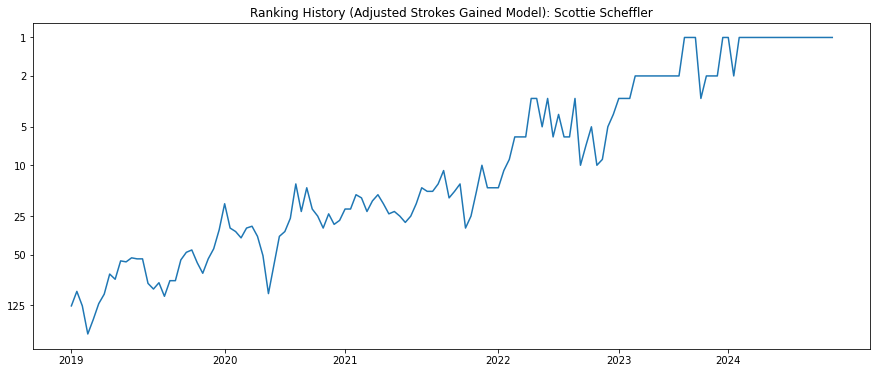

In [547]:
def plot_ranking_history_player(name):

    # Configurable minimum number of points per year
    min_points = 20  # Example: only include years with at least 10 data points

    dff = df3[(df3["name"] == name)&(df3["model_ranking"].notna())].reset_index(drop=True)

    # Line plot for EWMA
    plt.plot(dff.index, dff["model_ranking"])

    # Convert date column to datetime if necessary
    dff["date"] = pd.to_datetime(dff["date"])

    # Extract unique years
    unique_years = dff["date"].dt.year.unique()

    # Find the index corresponding to the first occurrence of each year,
    # but only include years with at least `min_points` data points
    year_indices = [
        dff[dff["date"].dt.year == year].index[0]
        for year in unique_years
        if len(dff[dff["date"].dt.year == year]) >= min_points
    ]

    # Filter unique years for labeling, ensuring they match the filtered indices
    filtered_years = [
        year
        for year in unique_years
        if len(dff[dff["date"].dt.year == year]) >= min_points
    ]

    # Set ticks at these indices
    plt.gca().set_xticks(year_indices)

    # Set tick labels as the filtered years
    plt.gca().set_xticklabels(filtered_years)

    # Set the y-axis to logarithmic scale (base 2)
    plt.yscale('log', base=2)

    # Find the maximum value in the 'end_rank' column
    max_rank = dff["model_ranking"].max()

    # Define the custom ticks you want to display
    custom_ticks = [1, 2, 5, 10, 25, 50, 125, 250, 500, 1000, 2000]

    # Filter ticks based on the maximum rank value
    y_ticks = [tick for tick in custom_ticks if tick <= max_rank]

    plt.yticks(y_ticks)

    # Optionally, set y-tick labels as the original values
    plt.gca().set_yticklabels(y_ticks)

    # Invert the y-axis
    plt.gca().invert_yaxis()

    # Set title
    plt.title(f"Ranking History (Adjusted Strokes Gained Model): {dff.name.values[0]}")

    # Display the plot
    plt.show();

plot_ranking_history_player("Scottie Scheffler")

## Plotting Functions

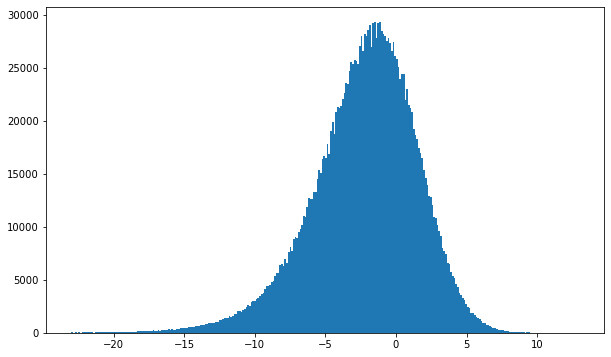

In [11]:
plt.rcParams['figure.figsize'] = (10, 6)

plt.hist(df1[df1["adjusted_strokes_gained"] > -23]["adjusted_strokes_gained"], bins=300)

plt.show();

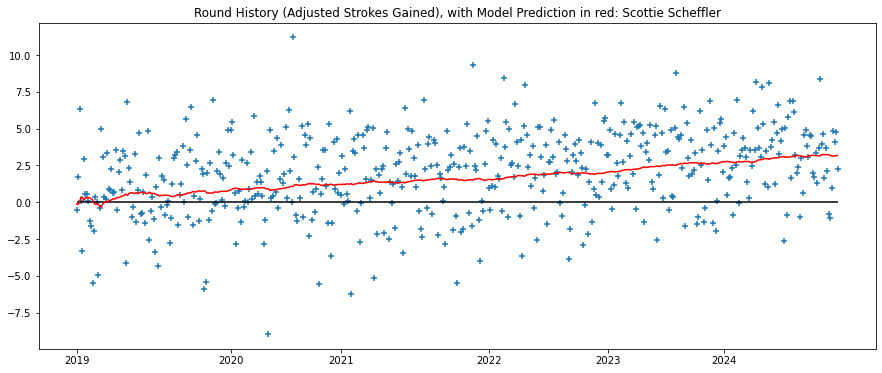

In [549]:
# Configurable minimum number of points per year
min_points = 20  # Example: only include years with at least 10 data points

dff = df2[df2["name"] == "Scottie Scheffler"].reset_index(drop=True)

# Scatter plot for original data
plt.scatter(dff.index, dff["adjusted_strokes_gained"], marker="+")

# Line plot for EWMA
plt.plot(dff.index, dff["ewma_1yr"], color="red")

# Horizontal line at y=0
plt.hlines(0, xmin=dff.index[0], xmax=dff.index[-1], color="black")

# Set title
plt.title(f"Round History (Adjusted Strokes Gained), with Model Prediction in red: {dff.name.values[0]}")

# Convert date column to datetime if necessary
dff["date"] = pd.to_datetime(dff["date"])

# Extract unique years
unique_years = dff["date"].dt.year.unique()

# Find the index corresponding to the first occurrence of each year,
# but only include years with at least `min_points` data points
year_indices = [
    dff[dff["date"].dt.year == year].index[0]
    for year in unique_years
    if len(dff[dff["date"].dt.year == year]) >= min_points
]

# Filter unique years for labeling, ensuring they match the filtered indices
filtered_years = [
    year
    for year in unique_years
    if len(dff[dff["date"].dt.year == year]) >= min_points
]

# Set ticks at these indices
plt.gca().set_xticks(year_indices)

# Set tick labels as the filtered years
plt.gca().set_xticklabels(filtered_years)

plt.show();

# Bottom